In [1]:
import glob
import xarray as xr
import os
import numpy as np
import warnings
import sys
import pickle
import matplotlib.pyplot as plt
sys.path.insert(0, '/home/disk/p/jkcm/Code')
from Lagrangian_CSET.CSET_data_classes import CSET_Flight
from Lagrangian_CSET import utils
from Lagrangian_CSET import met_utils as mu
from Lagrangian_CSET.LoopTimer import LoopTimer
%load_ext autoreload
%autoreload 2

In [2]:
scene_dict = {-1: 'NC',
              0: 'open',
              1: 'closed',
              2: 'homogen',
              3: 'disorg',
              4: 'too clear'}


def get_flight_nd(lat, lon, time, degrees):
    pass
    # get flight from time
    # get flight_data from near lat, lon
    # return 

In [3]:
x = utils.read_CSET_Lookup_Table(rf_num='all', sequences='all', legs=['c', 'p', 'd'], 
                                 variables=['Date', 'ST', 'ET', 'uhsas_conc1_M', 'Lat_S', 'Lat_E', 'Lon_S', 'Lon_E'])
start_dates = [utils.CSET_date_from_table(x['Date']['values'][i], x['ST']['values'][i])
               for i in range(len(x['Date']['values']))]
end_dates = [utils.CSET_date_from_table(x['Date']['values'][i], x['ET']['values'][i])
             for i in range(len(x['Date']['values']))]
lats = (x['Lat_S']['values'] + x['Lat_E']['values'])/2
lons = (x['Lon_S']['values'] + x['Lon_E']['values'])/2
times = [utils.CSET_date_from_table(x['Date']['values'][i], (x['ST']['values'][i]+x['ET']['values'][i])/2)
               for i in range(len(x['Date']['values']))]
Nds = x['uhsas_conc1_M']['values']
Nds[Nds=='-'] = np.nan
Nds = Nds.astype(float)
locs = np.array([lats, lons, times, Nds]).T

In [5]:
data_loc = r'/home/disk/eos4/jkcm/Data/CSET/Python/'
with open(os.path.join(data_loc, 'nep_scenes.pickle'), 'rb') as f:
    nep_scenes = pickle.load(f)

lats_nep = nep_scenes['lats_nep']
lons_nep = nep_scenes['lons_nep']
int_local_days_nep = nep_scenes['int_local_days_nep']
scenes_nep = nep_scenes['scenes_nep']

In [6]:
min_dists = []
best_scenes = []
failed_locs = []
nd_by_scene = {-1: [],
                 0: [],
                 1: [],
                 2: [],
                 3: [],
                 4: []}
for i, loc in enumerate(locs):
    lat, lon = loc[0], loc[1]
    dec_day = loc[2].timetuple().tm_yday + (loc[2].hour + loc[2].minute/60)/24
    local_day = dec_day + lon/360
    matching_days = int_local_days_nep == int(local_day)
    dists = [np.sqrt((lat-lat2)**2 + (lon-lon2)**2) for lat2, lon2 in zip(lats_nep[matching_days], lons_nep[matching_days])]
    if dists:
        best_i = np.argmin(dists)
        if dists[best_i] > 2:
            failed_locs.append(loc)
        else:
            min_dists.append(dists[best_i])
            assert len(scenes_nep[matching_days]) == len(dists)
            scene = scenes_nep[matching_days][best_i]
            best_scenes.append(scene)
            nd_by_scene[scene].append(loc[3])
    else:
        failed_locs.append(loc)

In [7]:
for s, locs in nd_by_scene.items():
    print("type {} ({}): total count is {}".format(s, scene_dict[s], len(locs)))
print("failed locs (too far): {}".format(len(failed_locs)))

type 0 (open): total count is 13
type 1 (closed): total count is 12
type 2 (homogen): total count is 0
type 3 (disorg): total count is 33
type 4 (too clear): total count is 0
type -1 (NC): total count is 103
failed locs (too far): 24


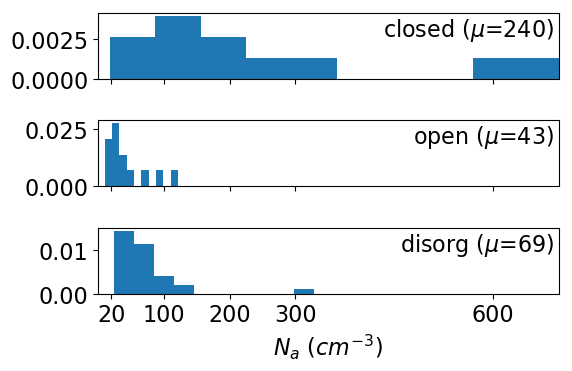

In [46]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(6,4))
ticks = [20, 200, 100, 300, 600]

for axi, scene in zip(ax, [1,0,3]):
    nds = nd_by_scene[scene]
    axi.set_xticks(ticks)
#     axi.set_ylabel("#")
    axi.hist(np.array(nds)[~np.isnan(nds)], density=True)#, bins = np.logspace(np.log10(5), np.log10(300), 21))
    axi.annotate('{} ($\mu$={:0.0f})'.format(str(scene_dict[scene]), np.nanmean(nds)), xy=(0.99, 0.95), xycoords='axes fraction', 
                 verticalalignment='top', horizontalalignment='right', fontsize=16)
ax[2].set_xlabel(r"$N_a$ ($cm^{-3}$)")
# plt.suptitle(r"Accum concentration", y=1.1)
# ax[2].set_xscale('log')
ax[2].set_xticks(ticks)
ax[2].set_xlim((0,700))
ax[2].set_xticklabels(ticks)

fig.tight_layout()

fig.savefig("/home/disk/user_www/jkcm/misc/agu/aerosol_pdf.png", dpi=600, bbox_inches='tight')
